# Training UPO Event Log Data for Event Abstraction

Importing all the libraries

In [1]:
import json
import os
import glob
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix


Defining a function that takes nested tuples and yield the inner values recursively. This function doesn't yield the tuples if the tuples' first value start with 'launch' or 'comment'. So, only the 'activity' logs are yielded. I did that on purpose because I believe the 'launch' and 'comment' logs are not significant for detecting the activities

In [2]:
def recursive_items(tupl):
    for value in tupl:
        if type(value) is tuple: 
            if value[0] != 'launch' and value[0] != 'comment':
                yield from recursive_items(value)
        else:
            yield value

# Loading the data from event log .json files

In [3]:
data = pd.DataFrame([])

The folderlist below stores names of the folders which containg logs describing different event labels. The folder names are the same as according to the labels of the event logs stored inside them

In [4]:
folderlist=["OpeningChrome","OpeningEclipse","ClosingChrome","ClosingEclipse","CreatingNewFolder", "DeletingFolder"]

In the next block of code I loop through each of the folders in the folderlist array change the directory to go inside them and then load all the json files through glob and then store the file names of the json files in an array then loop through each of the Json files to load the data into a dataframe

In [5]:
for i in folderlist:
    #print(i)
    os.chdir(r'C:\Users\datta\AppData\Local\UsageProbeLogs\{}'.format(i))
    files1 = glob.glob('*.json')
    for file in files1:
        #print(file)
        with open(file, "r") as upoLogFile:
            log_str = ""
            logdata = json.load(upoLogFile, object_pairs_hook=tuple)
            for value in recursive_items(logdata):
                if type(value) == str :
                    log_str = log_str + value + " "
                elif type(value) == int:
                    log_str = log_str + str(value) + " "
                elif type(value) == bool:
                    log_str = log_str + str(value) + " "
                elif type(value) == list:
                    log_str = log_str + " ".join(value) + " "
            data = data.append(pd.DataFrame({'log' :  log_str, 'label': i}, index=[0]), ignore_index=True)


Randomizing the rows in the dataframe

In [6]:
data = data.sample(frac=1).reset_index(drop=True)

In [7]:
data

,log,label
0,activity probe PROCESS_PROBE status ProcessCre...,ClosingEclipse
1,activity probe FILERESOURCE_PROBE status Creat...,OpeningEclipse
2,activity probe FILERESOURCE_PROBE status Chang...,OpeningEclipse
3,activity probe FILERESOURCE_PROBE status Delet...,DeletingFolder
4,activity probe FILERESOURCE_PROBE status Creat...,CreatingNewFolder
...,...,...
595,activity probe PROCESS_PROBE status ProcessCre...,OpeningChrome
596,activity probe FILERESOURCE_PROBE status Chang...,ClosingChrome
597,activity probe PROCESS_PROBE status ProcessCre...,ClosingChrome
598,activity probe PROCESS_PROBE status ProcessCre...,OpeningChrome


Initializing Snowball Stemmer to Stem the log text which will help in better classification

In [8]:
stemmer = SnowballStemmer('english')

Getting all the stopwords and store in a variable to filter out from the log string

In [9]:
words = stopwords.words("english")

Next, for every entry in the 'log' column of the dataframe, the following command substitutes all the non-alphabets into spaces and then loads the sub-strings separated by the spaces into a list using the split() command and then for all the values in that list, stems the values using the stemmer then joins all the list values as a single string separated by " " and then finally the .lower() on the string to turn all the upper case letters into lower case letters and finally add the string into a new column 'cleaned_log'

In [10]:
data['cleaned_log'] = data['log'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [11]:
data

,log,label,cleaned_log
0,activity probe PROCESS_PROBE status ProcessCre...,ClosingEclipse,activ probe process probe status processcr pro...
1,activity probe FILERESOURCE_PROBE status Creat...,OpeningEclipse,activ probe fileresourc probe status creat pat...
2,activity probe FILERESOURCE_PROBE status Chang...,OpeningEclipse,activ probe fileresourc probe status chang pat...
3,activity probe FILERESOURCE_PROBE status Delet...,DeletingFolder,activ probe fileresourc probe status delet pat...
4,activity probe FILERESOURCE_PROBE status Creat...,CreatingNewFolder,activ probe fileresourc probe status creat pat...
...,...,...,...
595,activity probe PROCESS_PROBE status ProcessCre...,OpeningChrome,activ probe process probe status processcr pro...
596,activity probe FILERESOURCE_PROBE status Chang...,ClosingChrome,activ probe fileresourc probe status chang pat...
597,activity probe PROCESS_PROBE status ProcessCre...,ClosingChrome,activ probe process probe status processcr pro...
598,activity probe PROCESS_PROBE status ProcessCre...,OpeningChrome,activ probe process probe status processcr pro...


Now, for each of the labels in the dataframe, the following command represents the labels as unique integer ID and stores into a new column in the dataframe called 'label_id'

In [12]:
data['label_id'] = data['label'].factorize()[0]

In [13]:
data

,log,label,cleaned_log,label_id
0,activity probe PROCESS_PROBE status ProcessCre...,ClosingEclipse,activ probe process probe status processcr pro...,0
1,activity probe FILERESOURCE_PROBE status Creat...,OpeningEclipse,activ probe fileresourc probe status creat pat...,1
2,activity probe FILERESOURCE_PROBE status Chang...,OpeningEclipse,activ probe fileresourc probe status chang pat...,1
3,activity probe FILERESOURCE_PROBE status Delet...,DeletingFolder,activ probe fileresourc probe status delet pat...,2
4,activity probe FILERESOURCE_PROBE status Creat...,CreatingNewFolder,activ probe fileresourc probe status creat pat...,3
...,...,...,...,...
595,activity probe PROCESS_PROBE status ProcessCre...,OpeningChrome,activ probe process probe status processcr pro...,5
596,activity probe FILERESOURCE_PROBE status Chang...,ClosingChrome,activ probe fileresourc probe status chang pat...,4
597,activity probe PROCESS_PROBE status ProcessCre...,ClosingChrome,activ probe process probe status processcr pro...,4
598,activity probe PROCESS_PROBE status ProcessCre...,OpeningChrome,activ probe process probe status processcr pro...,5


In [14]:
label_id_df = data[['label', 'label_id']].drop_duplicates().sort_values('label_id')

In [15]:
label_id_df

,label,label_id
0,ClosingEclipse,0
1,OpeningEclipse,1
3,DeletingFolder,2
4,CreatingNewFolder,3
6,ClosingChrome,4
8,OpeningChrome,5


The following command creates a plot to visualize the number of logs present for each label in the data

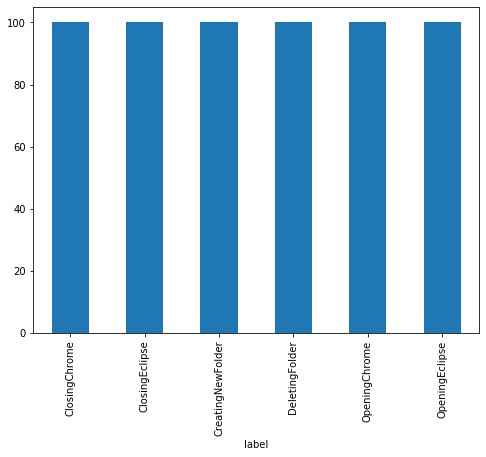

In [16]:
fig = plt.figure(figsize=(8,6))
data.groupby('label').cleaned_log.count().plot.bar(ylim=0)

The following command creates a csv file from the new modified dataframe and exports it through a zip file

In [17]:
os.chdir(r'C:\Users\datta\AppData\Local\UsageProbeLogs')
compression_opts = dict(method='zip', archive_name='out.csv')
data.to_csv('out.zip', index=False, compression=compression_opts)

# Training with Multinomial Naive Bayes Classifier

Next, we split the data into train and test.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_log'], data.label, test_size=0.2)

Creating a separate data frame for both train and test values

In [19]:
data_train = pd.DataFrame({'training_data': X_train, 'label': y_train})

In [20]:
data_train = data_train.reset_index()

In [21]:
data_train

,index,training_data,label
0,151,activ probe process probe status processcr pro...,ClosingChrome
1,43,activ probe process probe status processcr pro...,ClosingChrome
2,383,activ probe process probe status processdelet ...,ClosingEclipse
3,366,activ probe process probe status processdelet ...,OpeningEclipse
4,422,activ probe process probe status processdelet ...,ClosingEclipse
...,...,...,...
475,369,activ probe fileresourc probe status creat pat...,ClosingEclipse
476,465,activ probe fileresourc probe status chang pat...,CreatingNewFolder
477,449,activ probe fileresourc probe status chang pat...,DeletingFolder
478,192,activ probe process probe status processcr pro...,ClosingChrome


In [22]:
data_test = pd.DataFrame({'testing_data': X_test, 'label': y_test})

In [23]:
data_test = data_test.reset_index()

In [24]:
data_test

,index,testing_data,label
0,30,activ probe process probe status processcr pro...,OpeningChrome
1,309,activ probe process probe status processcr pro...,CreatingNewFolder
2,216,activ probe process probe status processdelet ...,OpeningEclipse
3,526,activ probe fileresourc probe status delet pat...,DeletingFolder
4,54,activ probe process probe status processdelet ...,ClosingEclipse
...,...,...,...
115,382,activ probe process probe status processcr pro...,CreatingNewFolder
116,157,activ probe process probe status processcr pro...,CreatingNewFolder
117,292,activ probe fileresourc probe status chang pat...,ClosingEclipse
118,457,activ probe fileresourc probe status delet pat...,DeletingFolder


Initializing the count vectorizer.

In [25]:
count_vect = CountVectorizer()

Next, I applied fit and transform on the 'training data' column from the training dataframe using the count vectorizer which creates a count matrix 

In [26]:
X_train_counts = count_vect.fit_transform(data_train['training_data'])

Then, initializing theTfidfTransformer()

In [27]:
tfidf_transformer = TfidfTransformer()

Then, using the TfidfTransformer, I convert the count matrix to a normalized tf-idf matrix

In [28]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

Initializing the Multinomial Naive Bayes Classifier

In [29]:
clf_MultiNB = MultinomialNB()

Fitting the Multinomial Naive Bayes Classifier with the training data

In [30]:
clf_MultiNB.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Creating an empty series called 'MultiNB'

In [31]:
MultiNB = pd.Series([])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


Now looping through each row of the testing dataframe and then using the multinomial naive bayes classifier, predicting the label of the of the log from the 'testing data' column and then putting the predicted value into the 'MultiNB' dataseries created earlier. Then, at the end of the loop adding the dataseries as a new column in the dataframe

In [32]:
for index, rows in data_test.iterrows():
    prediction = clf_MultiNB.predict(count_vect.transform([data_test['testing_data'][index]]))
    MultiNB[index] = prediction[0]
data_test.insert(3, "Multi-NB", MultiNB) 

In [33]:
data_test

,index,testing_data,label,Multi-NB
0,30,activ probe process probe status processcr pro...,OpeningChrome,OpeningChrome
1,309,activ probe process probe status processcr pro...,CreatingNewFolder,CreatingNewFolder
2,216,activ probe process probe status processdelet ...,OpeningEclipse,OpeningEclipse
3,526,activ probe fileresourc probe status delet pat...,DeletingFolder,DeletingFolder
4,54,activ probe process probe status processdelet ...,ClosingEclipse,ClosingEclipse
...,...,...,...,...
115,382,activ probe process probe status processcr pro...,CreatingNewFolder,OpeningEclipse
116,157,activ probe process probe status processcr pro...,CreatingNewFolder,CreatingNewFolder
117,292,activ probe fileresourc probe status chang pat...,ClosingEclipse,ClosingEclipse
118,457,activ probe fileresourc probe status delet pat...,DeletingFolder,DeletingFolder


Now I tried to load some unlabeled new event log files and tried to find the label 

In [35]:
os.chdir(r'C:\Users\datta\AppData\Local\UsageProbeLogs\UnlabeledLogs')

In [36]:
files_new = glob.glob('*.json')

In [37]:
data_new = pd.DataFrame([])
for file in files_new:
    with open(file, "r") as upoLogFile:
        #print(file)
        log_str = ""
        logdata = json.load(upoLogFile, object_pairs_hook=tuple)
        for value in recursive_items(logdata):
            if type(value) == str :
                log_str = log_str + value + " "
            elif type(value) == int:
                log_str = log_str + str(value) + " "
            elif type(value) == bool:
                log_str = log_str + str(value) + " "
            elif type(value) == list:
                log_str = log_str + " ".join(value) + " "
        data_new = data_new.append(pd.DataFrame({'log' :  log_str}, index=[0]), ignore_index=True)


In [38]:
data_new

,log
0,activity probe PROCESS_PROBE status ProcessCre...
1,activity probe PROCESS_PROBE status ProcessCre...
2,activity probe PROCESS_PROBE status ProcessCre...
3,activity probe PROCESS_PROBE status ProcessCre...
4,activity probe WINDOWSLOGRT_PROBE status Appli...
5,activity probe PROCESS_PROBE status ProcessCre...
6,activity probe PROCESS_PROBE status ProcessCre...
7,activity probe FILERESOURCE_PROBE status Chang...
8,activity probe FILERESOURCE_PROBE status Chang...
9,activity probe PROCESS_PROBE status ProcessCre...


In [39]:
data_new['cleaned'] = data_new['log'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [40]:
data_new

,log,cleaned
0,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...
1,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...
2,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...
3,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...
4,activity probe WINDOWSLOGRT_PROBE status Appli...,activ probe windowslogrt probe status applicat...
5,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...
6,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...
7,activity probe FILERESOURCE_PROBE status Chang...,activ probe fileresourc probe status chang pat...
8,activity probe FILERESOURCE_PROBE status Chang...,activ probe fileresourc probe status chang pat...
9,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...


In [41]:
for index, rows in data_new.iterrows():
    prediction = clf_MultiNB.predict(count_vect.transform([data_new['cleaned'][index]]))
    MultiNB[index] = prediction[0]
data_new.insert(2, "Predicted Label", MultiNB) 

In [42]:
data_new

,log,cleaned,Predicted Label
0,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...,ClosingChrome
1,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...,OpeningEclipse
2,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...,OpeningChrome
3,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...,ClosingChrome
4,activity probe WINDOWSLOGRT_PROBE status Appli...,activ probe windowslogrt probe status applicat...,ClosingChrome
5,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...,OpeningChrome
6,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...,OpeningEclipse
7,activity probe FILERESOURCE_PROBE status Chang...,activ probe fileresourc probe status chang pat...,OpeningChrome
8,activity probe FILERESOURCE_PROBE status Chang...,activ probe fileresourc probe status chang pat...,OpeningEclipse
9,activity probe PROCESS_PROBE status ProcessCre...,activ probe process probe status processcr pro...,CreatingNewFolder


I can verify that the predicted label in the dataframe above matches with the activity performed by me.

# Training with LinearSVC

I initialize the TfidfVectorizer to calculate the tf-idf vector for the cleaned log data in the dataframe. I set the sublinear_df to true to use a logarithmic form for frequency, mid_df to 5 which determines the minimum number of documents in which a word must be present in. norm is set to l2 to make sure that that the feature vectors have the euclidean norm of 1 and I set the n_gram range to (1, 3) which mean it will consider unigrams, bigrams and trigrams. 

In [43]:
tfidf = TfidfVectorizer(sublinear_tf = True, min_df = 5, norm='l2', encoding = 'latin-1', ngram_range=(1,3), stop_words = 'english')

Then I fit-transformed the vectorizer on the data from the training dataframe and loaded the data into 'features'

In [44]:
features = tfidf.fit_transform(data['cleaned_log']).toarray()

Then, I loaded the labels data from the dataframe into 'labels'

In [45]:
labels = data.label

Now, separating the features and labels into training and testing sets

In [46]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state = 0)

Now, creating a new dataframe to store the original and predicted labels

In [47]:
lab = {'Original Label' : labels_test}
test_labels_df = pd.DataFrame(lab)

In [48]:
test_labels_df

,Original Label
434,OpeningChrome
122,DeletingFolder
224,OpeningEclipse
479,ClosingEclipse
205,OpeningEclipse
...,...
598,OpeningChrome
89,ClosingEclipse
382,CreatingNewFolder
408,CreatingNewFolder


Initializing LinearSVC classifier

In [49]:
model_LinearSVC = LinearSVC()

Fitting the Linear SVC model on the features and labels data acquired

In [50]:
clf_LinearSVC = model_LinearSVC.fit(features_train, labels_train)

Predicting the labels of the features in the testing set which returns the predictions as a numpy array

In [51]:
pred_lsvc = clf_LinearSVC.predict(features_test)

Adding the labels predicted by the Linear SVC classifier into a new column in the 'labels_df' dataframe

In [52]:
test_labels_df['Prediction_LinearSVC'] = pred_lsvc

In [53]:
test_labels_df

,Original Label,Prediction_LinearSVC
434,OpeningChrome,OpeningChrome
122,DeletingFolder,DeletingFolder
224,OpeningEclipse,OpeningEclipse
479,ClosingEclipse,ClosingEclipse
205,OpeningEclipse,OpeningEclipse
...,...,...
598,OpeningChrome,OpeningChrome
89,ClosingEclipse,ClosingEclipse
382,CreatingNewFolder,CreatingNewFolder
408,CreatingNewFolder,CreatingNewFolder


Next, I plotted a confusion matrix to see the accuracy of the prediction by the Linear SVC classifier. As can be seen below, the classifier is working very good with 100% accuracy

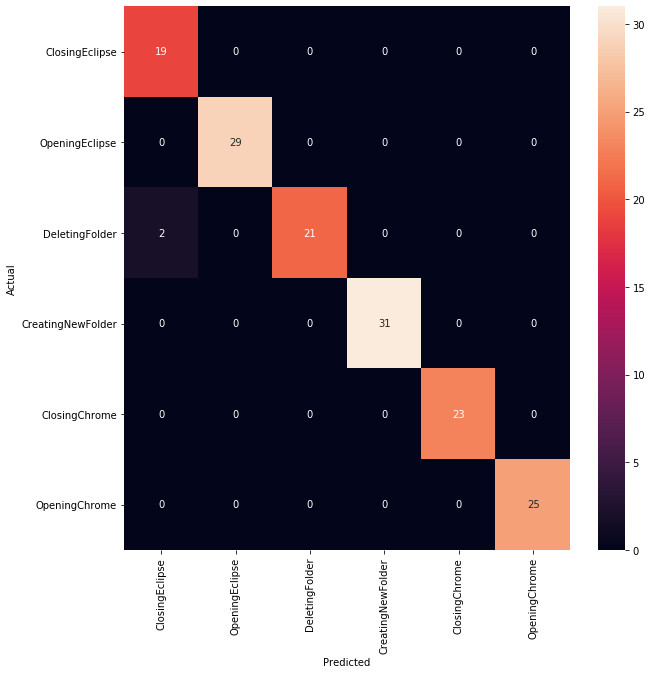

In [54]:
conf_mat = confusion_matrix(labels_test, pred_lsvc)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_id_df.label.values, yticklabels=label_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Training with Random Forest Classifier

Initializing Random Forest classifier

In [55]:
model_RandomForest = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

Fitting the Random Forest model on the features and labels data acquired

In [56]:
clf_RandomForest = model_RandomForest.fit(features_train, labels_train)

Predicting the labels of the features in the testing set which returns the predictions as a numpy array

In [57]:
pred_RandomForest = clf_RandomForest.predict(features_test)

Adding the labels predicted by the Random Forest classifier into a new column in the 'labels_df' dataframe

In [58]:
test_labels_df['Prediction_RandomForest'] = pred_RandomForest

In [59]:
test_labels_df

,Original Label,Prediction_LinearSVC,Prediction_RandomForest
434,OpeningChrome,OpeningChrome,OpeningChrome
122,DeletingFolder,DeletingFolder,ClosingChrome
224,OpeningEclipse,OpeningEclipse,OpeningEclipse
479,ClosingEclipse,ClosingEclipse,ClosingEclipse
205,OpeningEclipse,OpeningEclipse,OpeningEclipse
...,...,...,...
598,OpeningChrome,OpeningChrome,OpeningChrome
89,ClosingEclipse,ClosingEclipse,ClosingEclipse
382,CreatingNewFolder,CreatingNewFolder,CreatingNewFolder
408,CreatingNewFolder,CreatingNewFolder,CreatingNewFolder


Next, I plotted a confusion matrix to see the accuracy of the prediction by the Random Forest classifier. As can be seen below, the classifier is working very good with 100% accuracy

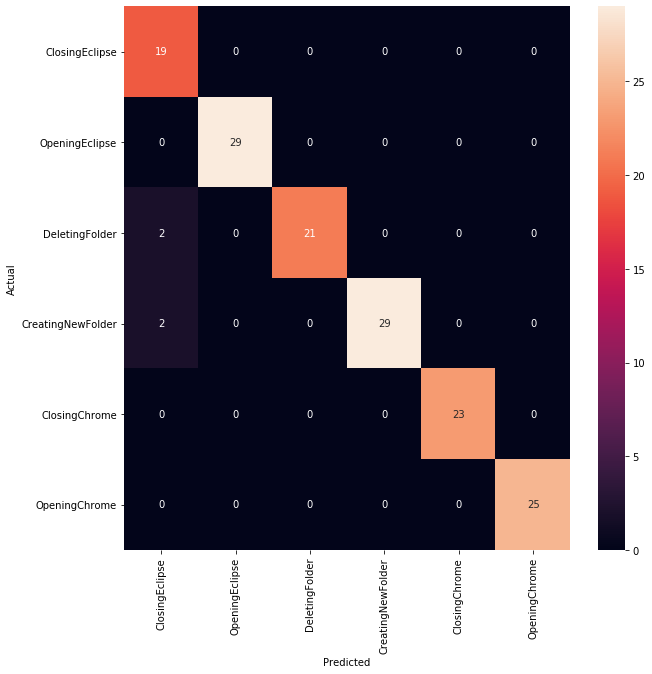

In [60]:
conf_mat = confusion_matrix(labels_test, pred_RandomForest)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_id_df.label.values, yticklabels=label_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Training with Logistic Regression

Initializing Random Forest classifier

In [61]:
model_LogisticRegression = LogisticRegression(random_state=0)

Fitting the Random Forest model on the features and labels data acquired

In [62]:
clf_LogisticRegression = model_LogisticRegression.fit(features_train, labels_train)

Predicting the labels of the features in the testing set which returns the predictions as a numpy array

In [63]:
pred_LogisticRegression = clf_LogisticRegression.predict(features_test)

Adding the labels predicted by the Linear SVC classifier into a new column in the 'labels_df' dataframe

In [64]:
test_labels_df['Prediction_LogisticRegression'] = pred_LogisticRegression

In [65]:
test_labels_df

,Original Label,Prediction_LinearSVC,Prediction_RandomForest,Prediction_LogisticRegression
434,OpeningChrome,OpeningChrome,OpeningChrome,OpeningChrome
122,DeletingFolder,DeletingFolder,ClosingChrome,CreatingNewFolder
224,OpeningEclipse,OpeningEclipse,OpeningEclipse,OpeningEclipse
479,ClosingEclipse,ClosingEclipse,ClosingEclipse,ClosingEclipse
205,OpeningEclipse,OpeningEclipse,OpeningEclipse,OpeningEclipse
...,...,...,...,...
598,OpeningChrome,OpeningChrome,OpeningChrome,OpeningChrome
89,ClosingEclipse,ClosingEclipse,ClosingEclipse,ClosingEclipse
382,CreatingNewFolder,CreatingNewFolder,CreatingNewFolder,CreatingNewFolder
408,CreatingNewFolder,CreatingNewFolder,CreatingNewFolder,CreatingNewFolder


Next, I plotted a confusion matrix to see the accuracy of the prediction by the Logistic Regression classifier. As can be seen below, the classifier is working very good with 100% accuracy

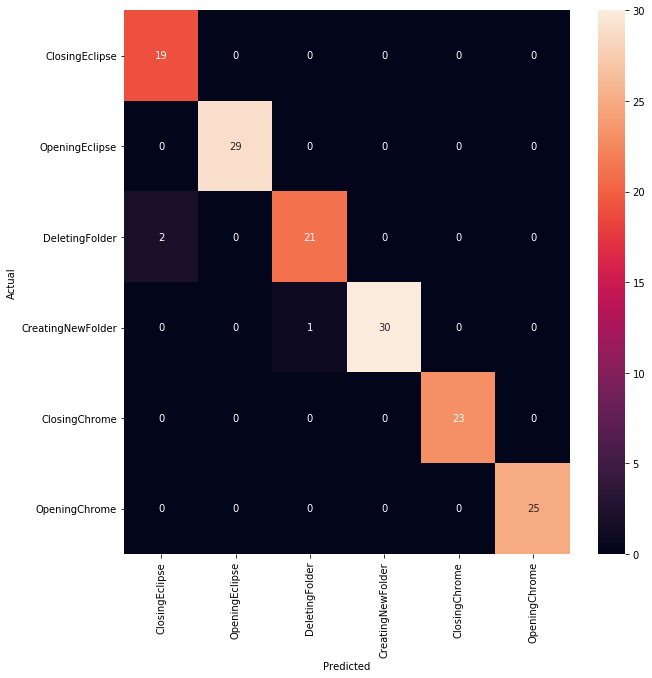

In [66]:
conf_mat = confusion_matrix(labels_test, pred_LogisticRegression)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_id_df.label.values, yticklabels=label_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Computing the Cross-Val Scores of different models

Creating an array to store the classifier to be able to loop through them

In [67]:
models = [
    model_LinearSVC,
    model_LogisticRegression,
    model_RandomForest    
]

Initializing a dataframe to store the accuracy values

In [68]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

Looping through each of the classifier models stored in the 'models' array and applying cross_val_score() function on each of these models with the features and labels acquired earlier. Setting the value of 'cv' to 5 which determines the cross-validation splitting strategy. 'cv=5' means the dataset will be divided into 5 folds and trained with 4 folds while keeping 1 fold for each time. Finally, I put the accuracies found from running cross_val_score() using each model on each of the folds of data and appended them into separate rows in a dataframe

In [69]:
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_id, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_id, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_id', 'accuracy'])

In [70]:
cv_df

,model_name,fold_id,accuracy
0,LinearSVC,0,0.991667
1,LinearSVC,1,0.983333
2,LinearSVC,2,0.975000
3,LinearSVC,3,0.983333
4,LinearSVC,4,1.000000
5,LogisticRegression,0,0.991667
6,LogisticRegression,1,0.983333
7,LogisticRegression,2,0.966667
8,LogisticRegression,3,0.975000
9,LogisticRegression,4,0.991667


Using a boxplot to visualize the data

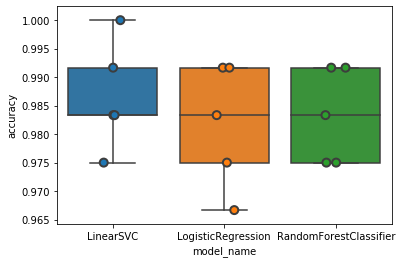

In [71]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Finding the mean accuracy for each of the model

In [72]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.986667
LogisticRegression        0.981667
RandomForestClassifier    0.983333
Name: accuracy, dtype: float64